## Pairs Trading Assignment (v2.0)
Updated attempt to learn pairs trading. This is almost trash though and hence the names. Details to be added.

In [1]:
# %pip install niftystocks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from niftystocks import ns

import warnings
warnings.filterwarnings('ignore')

In [2]:
start_date = '2020-01-01'
end_date = '2022-12-31'

[*********************100%***********************]  15 of 15 completed

1 Failed download:
['MCDOWELL-N.NS']: YFTzMissingError('possibly delisted; no timezone found')


Ticker         BRITANNIA.NS  COLPAL.NS  DABUR.NS  EMAMILTD.NS  GODREJCP.NS  \
Ticker                                                                       
BRITANNIA.NS       1.000000   0.847106  0.680353     0.820751     0.893305   
COLPAL.NS          0.847106   1.000000  0.413069     0.883731     0.896184   
DABUR.NS           0.680353   0.413069  1.000000     0.596532     0.614175   
EMAMILTD.NS        0.820751   0.883731  0.596532     1.000000     0.810913   
GODREJCP.NS        0.893305   0.896184  0.614175     0.810913     1.000000   
HINDUNILVR.NS      0.553752   0.181739  0.780267     0.394948     0.320143   
ITC.NS             0.797736   0.768807  0.462520     0.729980     0.691416   
JUBLFOOD.NS        0.561717   0.672773  0.235896     0.765330     0.453758   
MARICO.NS          0.766021   0.807669  0.468710     0.894733     0.718778   
NESTLEIND.NS       0.733761   0.784343  0.423947     0.601534     0.763847   
PGHH.NS            0.519149   0.637627  0.403261     0.579987   

<Axes: xlabel='Ticker', ylabel='Ticker'>

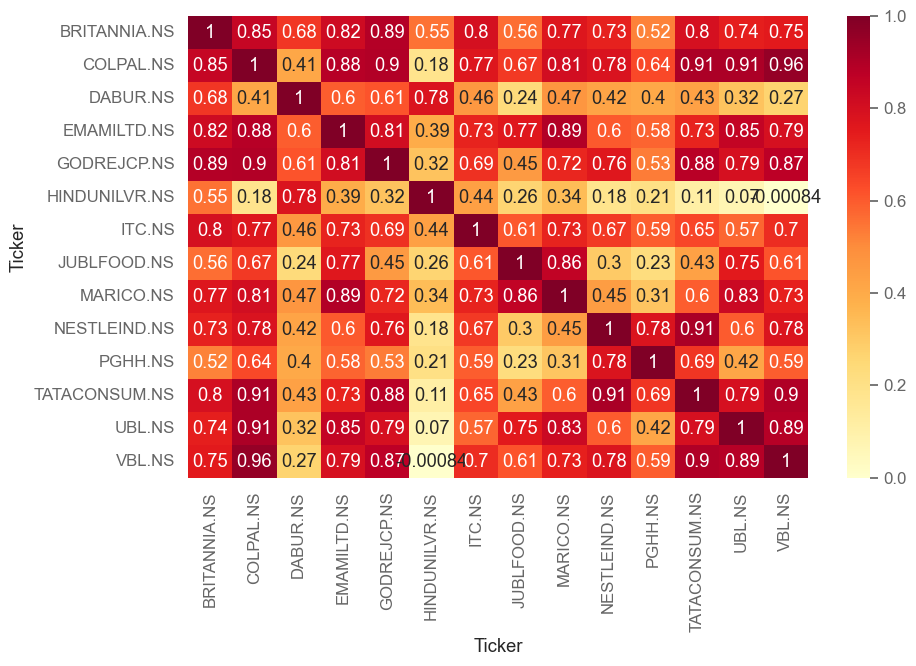

In [35]:
stocks = ns.get_nifty_fmcg_with_ns()
prices = yf.download(stocks, start = start_date, end = end_date)['Close']
log_prices = np.log(prices)
log_prices.dropna(axis=1, inplace=True)

print(log_prices.corr())
sns.heatmap(log_prices.corr(), annot = True, cmap ='YlOrRd')

In [36]:
pairs_first_draft = pd.DataFrame(columns=['stock1', 'stock2', 'corr'])
stock1_list, stock2_list, corr_list = [], [], []

for i in range(log_prices.shape[1]):
    for j in range(i+1, log_prices.shape[1]):
        check = log_prices.corr().iat[i,j]
        if (check >= 0.9):
            stock1_list.append(log_prices.columns[i])
            stock2_list.append(log_prices.columns[j])
            corr_list.append(check)
            

pairs_first_draft['stock1']=stock1_list
pairs_first_draft['stock2']=stock2_list
pairs_first_draft['corr']=corr_list

pairs_first_draft

,stock1,stock2,corr
0,COLPAL.NS,TATACONSUM.NS,0.907106
1,COLPAL.NS,UBL.NS,0.909678
2,COLPAL.NS,VBL.NS,0.956343
3,NESTLEIND.NS,TATACONSUM.NS,0.911648
4,TATACONSUM.NS,VBL.NS,0.901526


In [37]:
# %pip install statsmodels
# %pip install scipy

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import coint

We'll select the pair with the smallest $p$-value.

In [38]:
p_value = []

# p-values of the log returns

for i in range(pairs_first_draft.shape[0]):
    s1 = np.log(log_prices[pairs_first_draft['stock1'][i]])
    s2 = np.log(log_prices[pairs_first_draft['stock2'][i]])
    check = coint(s1,s2)[1]
    p_value.append(check)

pairs_first_draft['p-val'] = p_value

pairs_second_draft = pairs_first_draft.sort_values(by='p-val', ignore_index=True, ascending=True)

print(pairs_second_draft)

          stock1         stock2      corr     p-val
0   NESTLEIND.NS  TATACONSUM.NS  0.911648  0.082954
1      COLPAL.NS         UBL.NS  0.909678  0.107802
2      COLPAL.NS         VBL.NS  0.956343  0.138746
3  TATACONSUM.NS         VBL.NS  0.901526  0.277529
4      COLPAL.NS  TATACONSUM.NS  0.907106  0.451095


In [39]:
# Regression fit and spread
# y = gamma * x + c + z(spread)
# the hedge ratio here is gamma, given by res.params[1]

stock_pair = [pairs_second_draft['stock1'][0], pairs_second_draft['stock2'][0]]
res = OLS(log_prices[stock_pair[0]], add_constant(log_prices[stock_pair[1]])).fit()
hedge_ratio = res.params[1]

# we proceed to test now using the above hedge ratio
# in a different timeperiod <--- bad & weird

start_date = '2023-01-01'
end_date = '2025-03-31'

price_pair = yf.download(stock_pair, start=start_date, end=end_date)['Close']
price_pair_log = np.log(price_pair)
price_pair.head()

[*********************100%***********************]  2 of 2 completed


Ticker,NESTLEIND.NS,TATACONSUM.NS
Date,,
2023-01-02,950.582642,743.430847
2023-01-03,958.637085,748.160889
2023-01-04,948.558655,743.382141
2023-01-05,961.003662,744.942505
2023-01-06,966.312500,742.504456


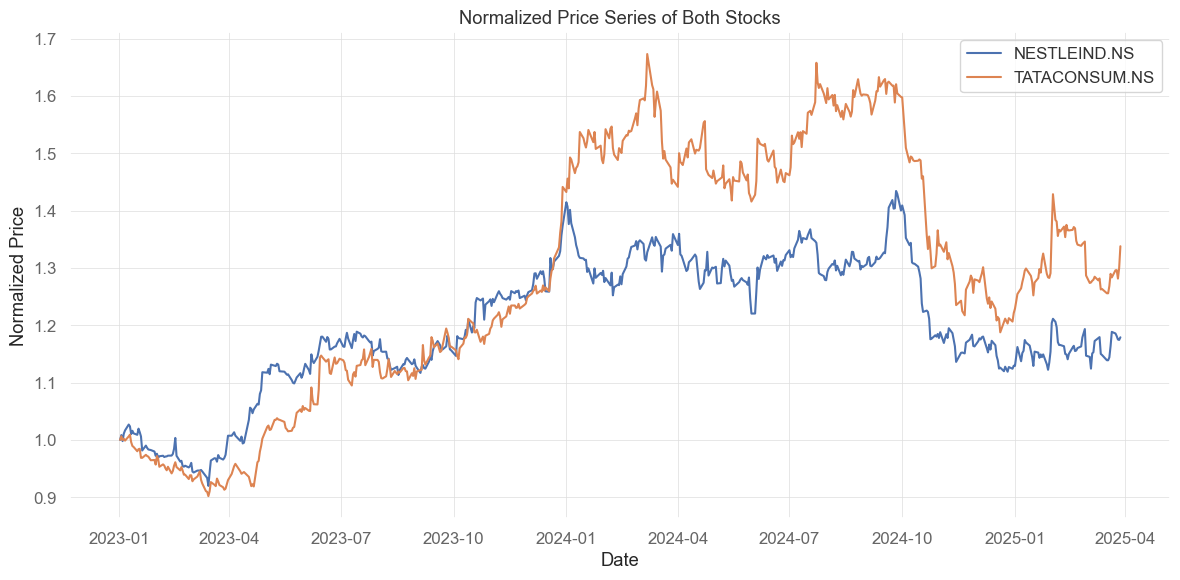

In [40]:
plt.figure(figsize=(12,6))
sns.lineplot(price_pair/price_pair.iloc[0], dashes=False)
plt.title('Normalized Price Series of Both Stocks')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

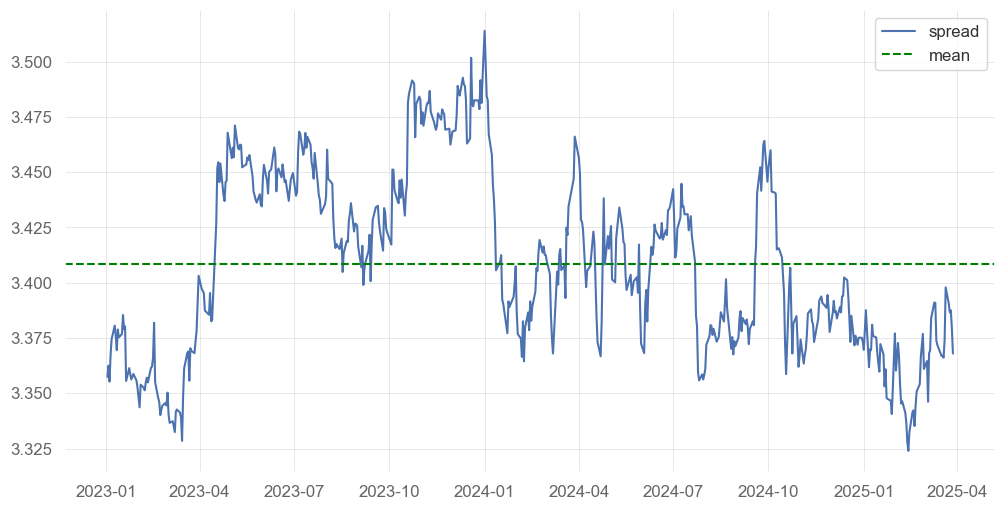

In [41]:
spread = price_pair_log[stock_pair[0]] - hedge_ratio*price_pair_log[stock_pair[1]]

plt.figure(figsize=(12,6))
plt.plot(spread, label='spread')
plt.axhline(y=spread.mean(), color='green', linestyle='dashed', label='mean')
plt.legend()

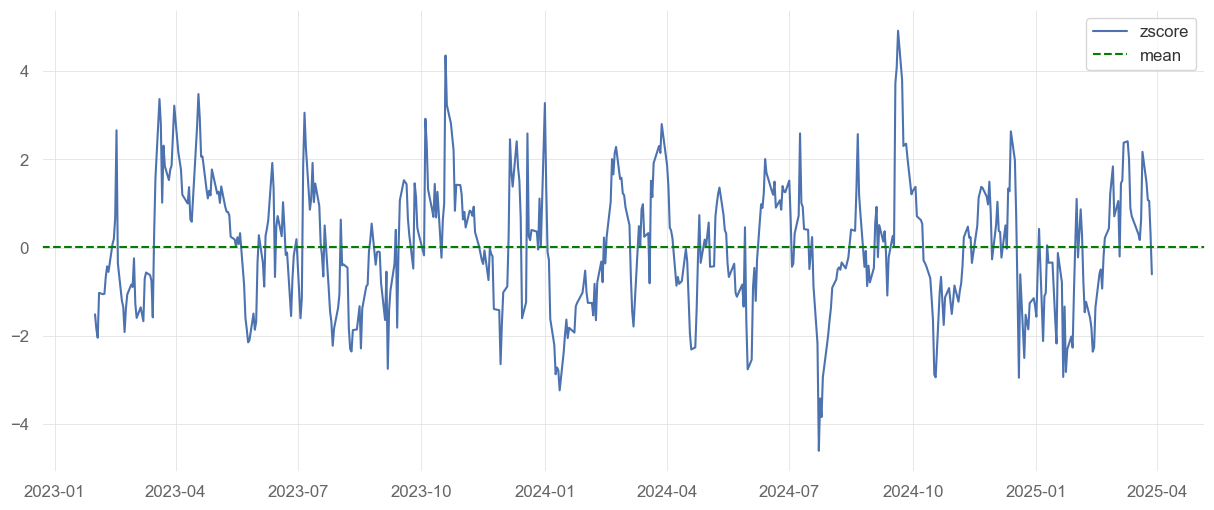

In [42]:
window = 20 # 20-day rolling mean of zscore
zscore = []
for i in range(window, len(spread)):
    calc = spread[i-window:i]
    zscore.append((spread[i]-calc.mean())/calc.std())
zscore = pd.Series(zscore, index = spread.index[window:])

plt.figure(figsize=(15,6))
plt.plot(zscore, label='zscore')
plt.axhline(y=zscore.mean(), color='green', linestyle='dashed', label='mean')
plt.legend()

### Step 3: Strategy and Backtesting

Set the threshold at z-score equal to 0.6 (I came up with trial and error, better optimizations in future versions).
If zscore > 0.6 => the first stock is growing away from the mean and so it will fall back and hence sell it, and buy the second stock. zscore < -0.6 => buy first stock, sell second

In [43]:
price_pair['zscore'] = zscore

conditions = [
  price_pair['zscore'] > 0.6,
  price_pair['zscore'] < -0.6,
]

choices = [-1, 1]

price_pair['signal'] = np.select(conditions, choices, default=0) 
# signal generation based on the z-score

price_pair.loc[abs(price_pair['zscore']) > 2, 'signal'] = 0 # stop-loss

# price_pair['pos_1'] = -price_pair['signal'].diff()
# price_pair['pos_2'] = -price_pair['pos_1']

price_pair.head(10)

Ticker,NESTLEIND.NS,TATACONSUM.NS,zscore,signal
Date,,,,
2023-01-02,950.582642,743.430847,NaN,0
2023-01-03,958.637085,748.160889,NaN,0
2023-01-04,948.558655,743.382141,NaN,0
2023-01-05,961.003662,744.942505,NaN,0
2023-01-06,966.312500,742.504456,NaN,0
2023-01-09,976.053345,747.965820,NaN,0
2023-01-10,973.052673,750.208862,NaN,0
2023-01-11,960.143555,740.505188,NaN,0
2023-01-12,965.729431,735.580200,NaN,0


In [44]:
investment = 100000
capital_two = investment/2
capital_one = investment - capital_two

share_one = capital_one//(price_pair[stock_pair[0]].iloc[0])
share_two = capital_two//(price_pair[stock_pair[1]].iloc[0])

pft = pd.DataFrame()
pft['ret_1'] = price_pair[stock_pair[0]].diff()*price_pair['signal'].shift(1)*share_one
pft['net_1'] = capital_one + pft['ret_1'].cumsum()

pft['ret_2'] = -price_pair[stock_pair[1]].diff()*price_pair['signal'].shift(1)*share_two
pft['net_2'] = capital_two + pft['ret_2'].cumsum()


pft['net'] = pft['net_1'] + pft['net_2']

In [45]:
# %pip install quantstats
import quantstats

print(f"Net profit: {100*(pft['net'].iloc[-1]/investment-1):.3f} %")
print(f"Maximum drawdown: {quantstats.stats.max_drawdown(pft['net'].pct_change())*100:.3f} %")
print(f"Sharpe ratio: {quantstats.stats.sharpe(pft['net']):.3f}")

Net profit: 30.229 %
Maximum drawdown: -4.742 %
Sharpe ratio: 1.475


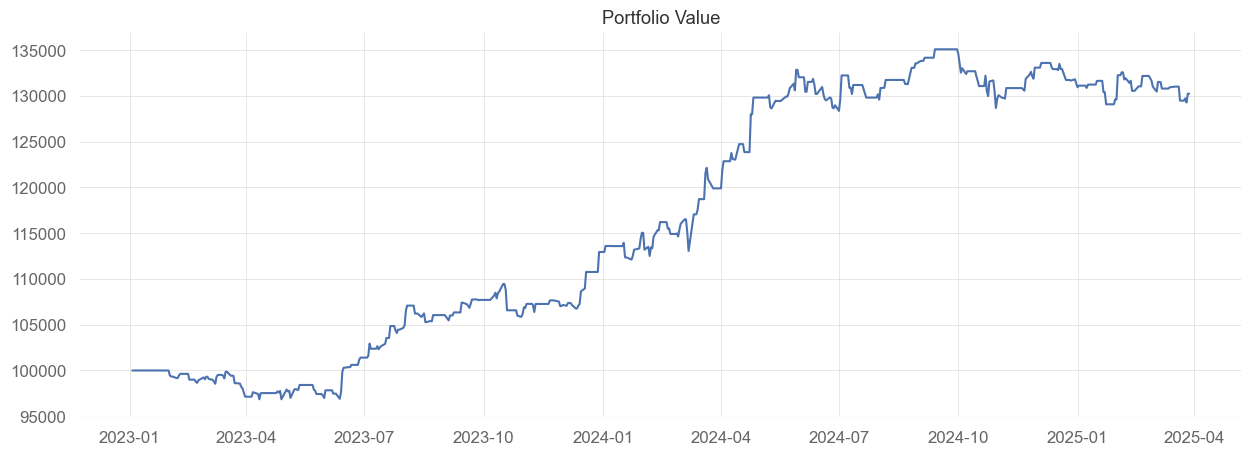

In [46]:
plt.figure(figsize=(15,5))
plt.title("Portfolio Value")
plt.plot(pft['net'])
plt.show()

We got sharpe ratio 1.4 and net profit of 30% which is good ig? Idk. We will now compare against 'buy & hold' of both stocks individually and then 50-50 investment distribution.

In [47]:
price_pair['ret_stock0'] = price_pair[stock_pair[0]].pct_change() 
price_pair['ret_stock1'] = price_pair[stock_pair[1]].pct_change() 

price_pair['bh_s0_val'] = investment * (1 + price_pair['ret_stock0']).cumprod() #buy&hold stock 0
price_pair['bh_s1_val'] = investment * (1 + price_pair['ret_stock1']).cumprod() #buy&hold stock 1

price_pair['bh_port_val'] = investment * (1 + (0.5 * price_pair['ret_stock0'] + 0.5 * price_pair['ret_stock1'])).cumprod() # invest 50-50 in both

In [48]:
print(f"Net profit in Buy&Hold Stock 0: {100*(price_pair['bh_s0_val'].iloc[-1]/investment-1):.3f} %")
print(f"Maximum drawdown: {quantstats.stats.max_drawdown(price_pair['bh_s0_val'].pct_change())*100:.3f} %")
print(f"Sharpe ratio: {quantstats.stats.sharpe(price_pair['bh_s0_val']):.3f}")

Net profit in Buy&Hold Stock 0: 17.892 %
Maximum drawdown: -21.978 %
Sharpe ratio: 0.481


In [49]:
print(f"Net profit in Buy&Hold Stock 1: {100*(price_pair['bh_s1_val'].iloc[-1]/investment-1):.3f} %")
print(f"Maximum drawdown: {quantstats.stats.max_drawdown(price_pair['bh_s1_val'].pct_change())*100:.3f} %")
print(f"Sharpe ratio: {quantstats.stats.sharpe(price_pair['bh_s1_val']):.3f}")

Net profit in Buy&Hold Stock 1: 33.776 %
Maximum drawdown: -29.009 %
Sharpe ratio: 0.701


In [50]:
print(f"Net profit in Buy&Hold 50-50: {100*(price_pair['bh_port_val'].iloc[-1]/investment-1):.3f} %")
print(f"Maximum drawdown: {quantstats.stats.max_drawdown(price_pair['bh_port_val'].pct_change())*100:.3f} %")
print(f"Sharpe ratio: {quantstats.stats.sharpe(price_pair['bh_port_val']):.3f}")

Net profit in Buy&Hold 50-50: 27.204 %
Maximum drawdown: -24.002 %
Sharpe ratio: 0.709


So, on this pair of stocks, our strategy didn't actually perform that badly. But there are several parameters which need serious fine-tuning which will be done in the future.